# **Tutorial 6: Radiative Convective Equilibrium**


**Week 1, Day 5, Climate Modeling**

**Content creators:** Jenna Pearson

**Content reviewers:** Yunlong Xu, Will Gregory, Peter Ohue, Derick Temfack, Zahra Khodakaramimaghsoud, Peizhen Yang, Younkap Nina Duplex, Ohad Zivan, Chi Zhang

**Content editors:** Brodie Pearson, Abigail Bodner, Ohad Zivan, Chi Zhang

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS



# **Tutorial Objectives**

In this tutorial students will learn about radiative-convective-equilibrium. Much of the code shown here was taken from [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook/home.html) by Brian Rose. Students are encouraged to visit this website for more tutorials and background on these models.

By the end of this tutorial students will be able to:
* Implement a radiative-convective equilibrium model using the python package `climlab`.
* Understand how this model builds off the one-dimensional radiative balance model used in the previous tutorials.

# Setup

In [69]:
# google colab installs 
# # note the conda install takes quite a while, but conda is REQUIRED to properly download the dependencies (that are not just python packages)
# !pip install condacolab &> /dev/null           # need to use conda installation of climlab, pip won't work. condacolab is a workaround
# import condacolab
# condacolab.install()
# !mamba install -c anaconda cftime xarray numpy &> /dev/null    # for decoding time variables when opening datasets
# !mamba install -c conda-forge metpy climlab &> /dev/null

In [6]:
#imports 

# I have to run this twice to get it to work...no idea why
#ohad comment: on jupyter notebook is works. only problem is the climlab dependencies  

import xarray as xr                     # used to manipulate data and open datasets
import numpy as np                      # used for algebra/arrays
import urllib.request                   # used to download data from the internet
import climlab                          # one of the models we are using
import matplotlib.pyplot as plt         # used for plotting
import metpy                            # used to make Skew T Plots of temperature and pressure
from metpy.plots import SkewT           # plotting function used widely in climate science
import pooch
import os

In [2]:
# @title Figure Settingsimport ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

## Helper Functions

In [3]:
#  Some imports needed to make and display animations in Part 4
from IPython.display import HTML
from matplotlib import animation
plt.rcParams["animation.html"] = "jshtml"
plt.ioff()

# these three functions are used to make videos at the end of the tutorial

def initial_figure(model):
    fig = plt.figure(figsize=(6,6))
    lines = []
    
    skew = SkewT(fig,rotation=30)
    #  plot the observations
    skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')    
    lines.append(skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK, 
              linestyle='-', linewidth=2, color='C0', label='RC model (all gases)')[0])
    skew.ax.legend()
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-60, 75)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=1.5, label = 'dry adiabats')
    # skew.plot_moist_adiabats(linewidth=1.5, label = 'moist adiabats')
    skew.ax.set_xlabel('Temperature ($^\circ$C)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    lines.append(skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
                  markersize=8, color='C0', )[0])
    return fig, lines

def animate(day, model, lines):
    lines[0].set_xdata(np.array(model.Tatm)-climlab.constants.tempCtoK)
    lines[1].set_xdata(np.array(model.Ts)-climlab.constants.tempCtoK)
    #lines[2].set_xdata(np.array(model.q)*1E3)
    # lines[-1].set_text('Day {}'.format(int(model.time['days_elapsed'])))
    # This is kind of a hack, but without it the initial frame doesn't appear
    if day != 0:
        model.step_forward()
    return lines

# to setup the skewT and plot observations
def make_basic_skewT():
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)
    skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-90, 45)
    # Add the relevant special lines
    #skew.plot_dry_adiabats(linewidth=1.5, label = 'dry adiabats')
    # skew.plot_moist_adiabats(linewidth=1.5, label = 'moist adiabats')
    #skew.plot_mixing_lines()
    skew.ax.legend()
    skew.ax.set_xlabel('Temperature (degC)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    return skew

# to setup the skewT and plot observations
def make_skewT():
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)
    skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-90, 45)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=1.5, label = 'dry adiabats')
    # skew.plot_moist_adiabats(linewidth=1.5, label = 'moist adiabats')
    #skew.plot_mixing_lines()
    skew.ax.legend()
    skew.ax.set_xlabel('Temperature (degC)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    return skew

# to add a model derived profile to the skewT figure
def add_profile(skew, model, linestyle='-', color=None):
    line = skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK,
             label=model.name, linewidth=2)[0]
    skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
              markersize=8, color=line.get_color())
    skew.ax.legend()

In [4]:
# @title Video 1: Radiative-Convective Equilibrium
#Tech team will add code to format and display the video

# Section 1: Reproducing Data from the Last Tutorial's One-dimensional Radiative Equilibrium Model Using Climlab

In [7]:
# data source : http://thredds.atmos.albany.edu:8080/thredds/fileServer/CESMA/cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc

# filename: "cpl_1850_f19-Q-gw-only.cam.h0.nc"
url_sq = "https://osf.io/c6q4j/download/"
ds = xr.open_dataset(pooch.retrieve(url_sq,known_hash=None)) # ds = dataset

# data source: https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis/Monthlies/pressure/air.mon.1981-2010.ltm.nc
# ohad comment: the file dates are broken completely. xarray is really powerful. if it fails, something is wrong with the file
url_ncep_air = "https://osf.io/w6cd5/download/"
ncep_air = xr.open_dataset(pooch.retrieve(url_ncep_air,known_hash=None)) # ds = dataset

# take global, annual average
weight_factor = ds.gw / ds.gw.mean(dim='lat')
Qglobal = (ds.Q * weight_factor).mean(dim=('lat','lon','time'))

# use 'lev=Qglobal.lev' to create an identical vertical grid to water vapor data
mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)

radmodel = climlab.radiation.RRTMG(name='Radiation (all gases)',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                             )

# need to take the average over space and time
# the grid cells are not the same size moving towards the poles, so we weight by the cosine of latitude to compensate for this 
coslat = np.cos(np.deg2rad(ncep_air.lat))
weight = coslat / coslat.mean(dim='lat')

Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time'))

# take a single step forward to the diagnostics are updated and there is some energy imbalance
radmodel.step_forward()

# run the model to equilibrium (the difference between ASR and OLR is a very small number)
while np.abs(radmodel.ASR - radmodel.OLR) > 0.001:
    radmodel.step_forward()

skew = make_basic_skewT()
add_profile(skew, radmodel)
skew.ax.set_title('Pure Radiative Equilibrium', fontsize=18);
# CURRENTLY IT IS NOT PLOTTING THIS SKEW-T PLOT

C:\ProgramData\Anaconda3\envs\climatematch_test\lib\site-packages\xarray\coding\times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\ProgramData\Anaconda3\envs\climatematch_test\lib\site-packages\xarray\coding\times.py:154: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
C:\ProgramData\Anaconda3\envs\climatematch_test\lib\site-packages\xarray\core\indexing.py:556: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using c

NameError: name '_rrtmg_sw' is not defined

# Section 2: Radiative-Convective Equilibrium

From the plot you just made, one of the largest differences between observations and the pure radiation model with all gases lies in the lower atmosphere, where the surface air temperature is 20 degrees too warm and the 200 hPa pressure surface is 40 degrees too cold. What could be the issue?

One thing we have not included in our model yet is dynamics (motion of the air). The model's temperature profile is what's known as **statically unstable** (note this definition of stability is different than that used in the previous tutorials).

Here **static** means not due to wind, and **unstable** means the atmopshere wants to adjust to a different state because the surface air is relatively light and wants to rise into upper layers of the atmosphere. As the air rises, it creates **convective turbulence** (similar to boiling water, where convective circulation is introduced from heating water from below). The rising air, and the resultant turbulence, mixes the atmospheric column. This mixing often occurs across the **troposphere**, which is roughly the lowest 10km of the atmosphere. Most of the weather we experience lies in the troposphere. 

When air rises [adiabatically](httphttps://forecast.weather.gov/glossary.php?word=adiabatics://), it expands and cools due to the lower pressure.  The *rate* of cooling depends on whether the air is saturated with wator vapor. When rising air is unsaturated, it cools following the dry adiabats. If the air saturates, it cools at a lesser rate denoted by the moist adiabats (we did not have time to discuss these moisture effects in the mini-lecture). 

To identify unstable atmopsheric layers, let's take another look at the SkewT plot, but this time we will plot the dry adiabats. We can then compare the rates of cooling of our model to these adiabats.

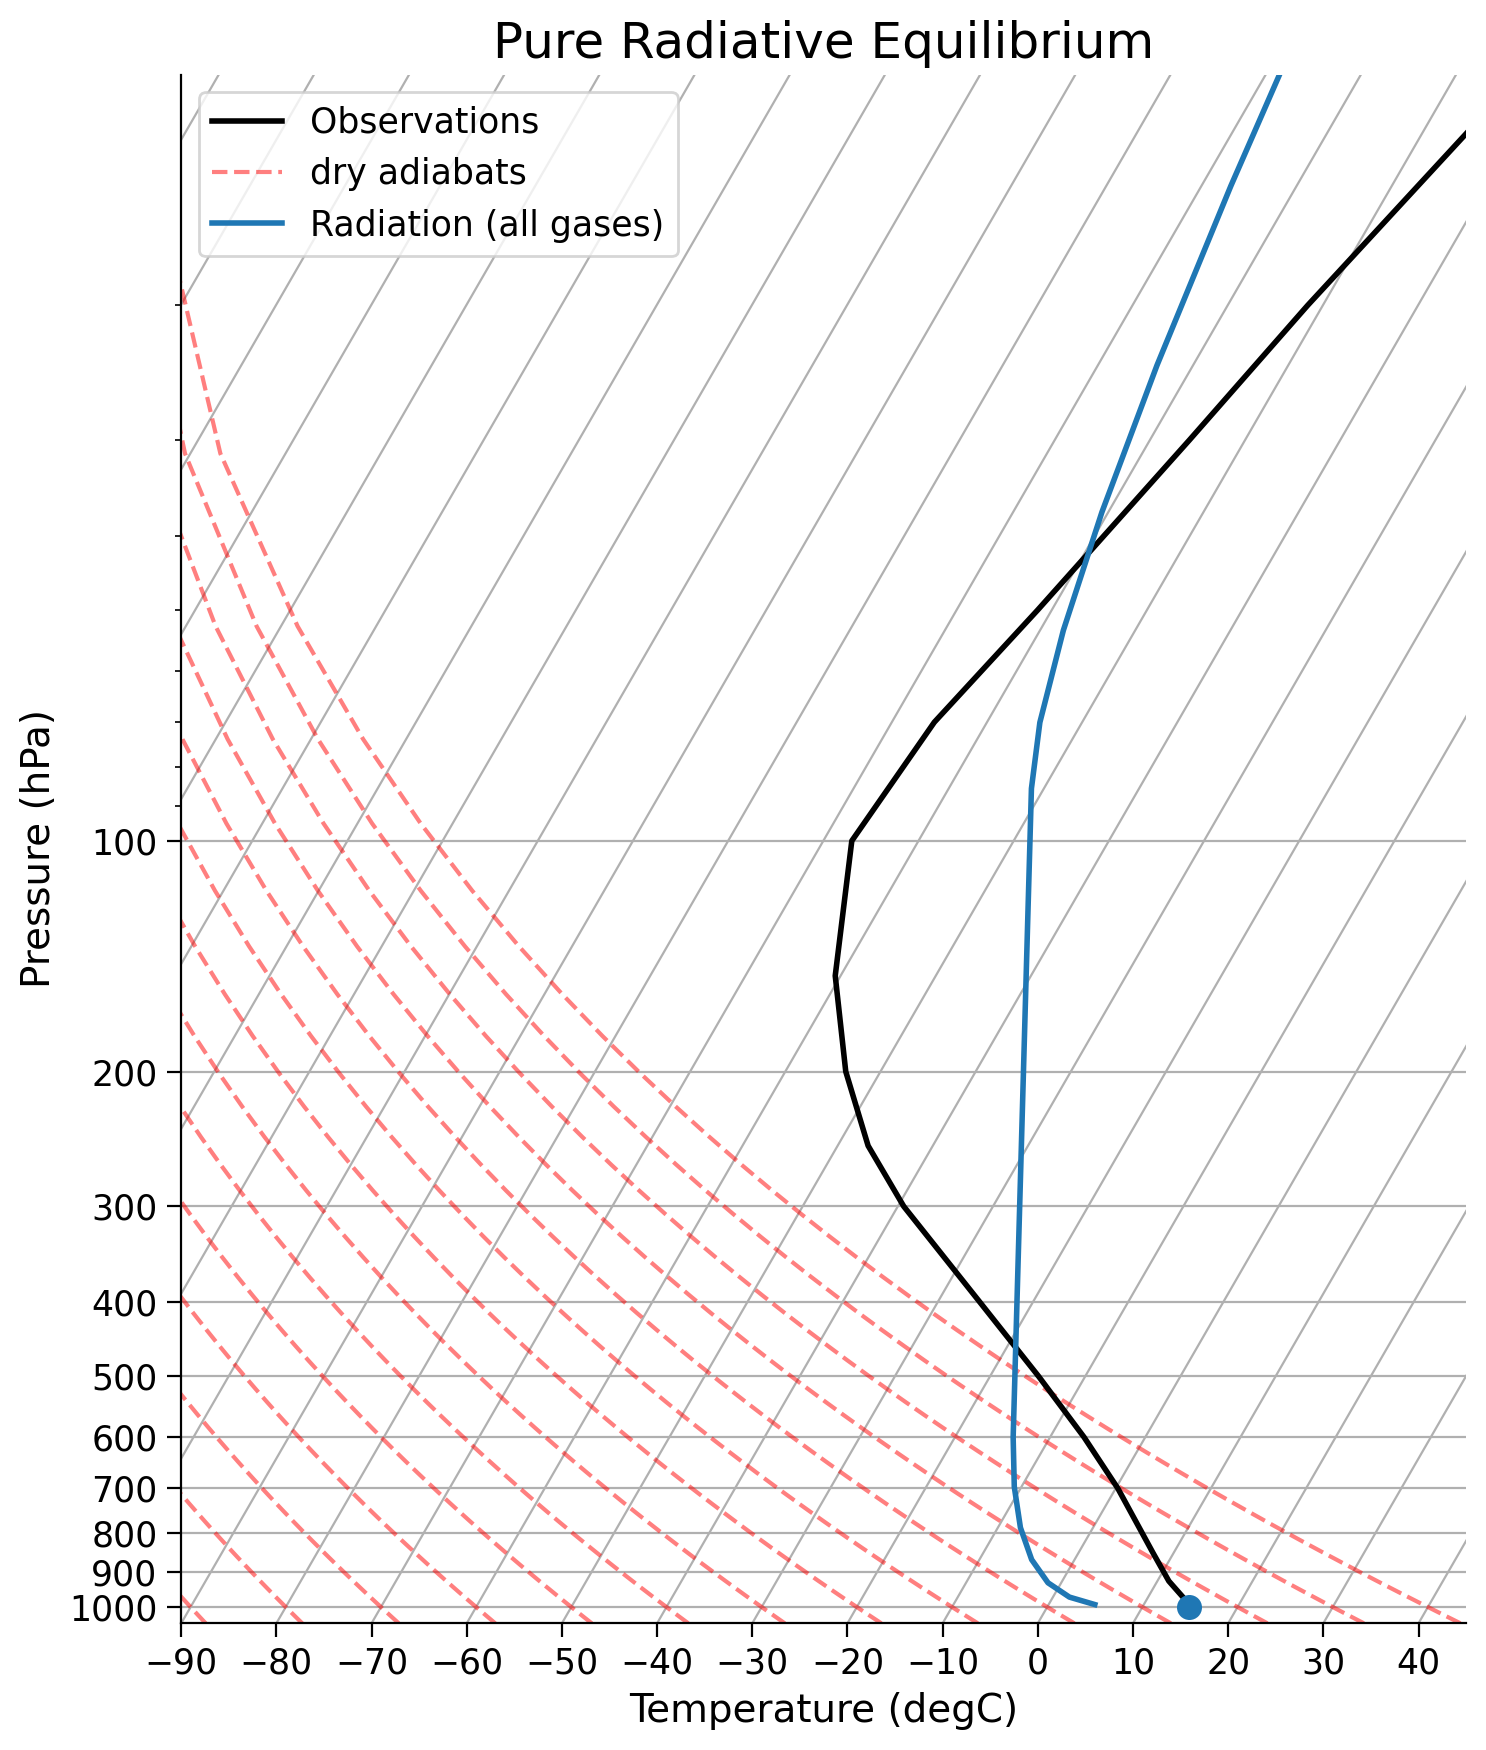

In [8]:
skew = make_skewT()
add_profile(skew, radmodel)
skew.ax.set_title('Pure Radiative Equilibrium', fontsize=18);
# CURRENTLY IT IS NOT PLOTTING THIS SKEW-T PLOT



Near the surface, the reanalysis temperature profile is steeper than the dry adiabats. In these layers vertical motion is inhibited, and the surface conditions are considered stable. However, the model profile is shallower than the dry adiabats. In the model, the surface air is *statically unstable*, which would lead to convective mixing if this physical process was included in the model (the model currently only includes radiative processes). **In this tutorial we will see whether including convective mixing in our model can bring the model closer to the reanalysis temperature profile.**


To build a radiative-convective model we can take the radiative model we have already made and couple it to a convective model. Here the term **couple** implies there is communication between the models such that their effects are both incorporated into the final product, which in our case is the temperature profile.

In [9]:
# restate the model here for ease of coding

# make a model on same vertical domain as the water vapor data
mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)

# create the radiation model
rad = climlab.radiation.RRTMG(name='Radiation (net)',
                              state=mystate,
                              specific_humidity=Qglobal.values,
                              timestep = climlab.constants.seconds_per_day,
                              albedo = 0.25,  # surface albedo, tuned to give reasonable ASR for reference cloud-free model
                             )

# create the convection model
conv = climlab.convection.ConvectiveAdjustment(name='Convection',
                                               state=mystate,
                                               adj_lapse_rate=6.5,     # the adiabatic lapse rate of the atmopshere
                                               timestep=rad.timestep,  # same timestep as radiation model
                                              )
# couple the two components
rcm = climlab.couple([rad, conv], name='Radiative-Convective Model')

Now let's run the radiation part to equilibrium, which should give us the same profile as in the previous section. Once we get this *radiative equilibrium* profile we will add convective mixing physics to the model and continue running it until it reaches *radiative-convective equilibrium*.

The new model does not actually resolve the actual vertical motion and mixing that occurs in convection. Instead, the model includes a *parameterization* for convection which automatically mixes regions of the atmospheric column that are statically unstable.

In [10]:
# run JUST the radiative component to equilibrium
for n in range(1000):
    rcm.subprocess['Radiation (net)'].step_forward()

# compute diagnostics
rcm.compute_diagnostics()

#  plot the resulting profile (our initial condition once we turn on the physics)
fig, lines = initial_figure(rcm)

# this animation can take a while
animation.FuncAnimation(fig, animate, 50, fargs=(rcm, lines))

NameError: name '_rrtmg_sw' is not defined

Adding convective mixing to the initially unstable temperature profile leads to an instant mixing of air throughout the lower atmosphere, moving the profile towards the observations. The balance at play is between radiative process that warm the surface and cool the troposphere (lower atmosphere) as well as convection which moves heat away from the surface, leading to a colder surface and warmer troposphere. Note the differences in surface versus tropospheric temperatures in the new versus old equilibrium profiles.

## Questions 2

1. The static instability was removed in the first time step! In reality, which process do you think changes temperature faster, convection or radiation?
2. What do you think the next step would be to move towards a more realistic climate model?

In [80]:
# to_remove explanation

"""
1. In nature, convection changes the temperature of the atmospheric column faster than radiative processes because convection involves quick movement of air (and heat) form one place to another. Our model takes this into account by having convective processes act instantaneously on unstablities due to unstable temperature profiles.
2. Next steps could include expanding in space (x,y,z) and including other processes (such as dynamics) and additional components of the climate system (ocean etc.). We'll talk about this more in Tutorial 7 where you will work with the Community Earth System Model (CESM).
"""

"\n1. In nature, convection changes the temperature of the atmospheric column faster than radiative processes because convection involves quick movement of air (and heat) form one place to another. Our model takes this into account by having convective processes act instantaneously on unstablities due to unstable temperature profiles.\n2. Next steps could include expanding in space (x,y,z) and including other processes (such as dynamics) and additional components of the climate system (ocean etc.). We'll talk about this more in Tutorial 7 where you will work with the Community Earth System Model (CESM).\n"

## Coding Exercises 2

1. Recreate the video above except using an isothermal atmosphere (uniform temperature profile) set to the surface temprature. Does the equilbrium profile look any different than the one you made before?

In [81]:
#################################################
# Students: Fill in missing code (...) and comment or remove the next line
raise NotImplementedError("Student exercise: Recreate the video above except using an isothermal atmosphere (uniform temperature profile) set to the surface temprature.")
#################################################

# set initial temperature profile to be the surface temperature (isothermal)
rcm.state.Tatm[:] = ...

# compute diagnostics
...

#  plot initial data
fig, lines = ...

NotImplementedError: Student exercise: Recreate the video above except using an isothermal atmosphere (uniform temperature profile) set to the surface temprature.

In [11]:
# to_remove solution

# set initial temperature profile to be the surface temperature (isothermal)
rcm.state.Tatm[:] = rcm.state.Ts

# compute diagnostics
rcm.compute_diagnostics()

#  plot initial data
fig, lines = initial_figure(rcm)

# make animation
animation.FuncAnimation(fig, animate, 150, fargs=(rcm, lines))

NameError: name '_rrtmg_sw' is not defined